In [1]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
import htmd.ui as ht
import htmd.molecule.voxeldescriptors as vd
import htmd.vmdviewer as vmdviewer
import csv
import pickle
import numpy as np
from tqdm import *
import bcolz as bc
import glob
import os
import random
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

%matplotlib inline

# import pytraj as pt
import nglview as nv

/usr/local/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



HTMD License accepted automatically. Check license here: https://raw.githubusercontent.com/Acellera/htmd/master/htmd/LICENCE.txt

For advanced features (e.g. parameterize) and to remove this message, we recommend registering. Run htmd_register in your terminal.


2018-05-03 22:43:39,544 - binstar - INFO - Using Anaconda API: https://api.anaconda.org



Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. 
https://dx.doi.org/10.1021/acs.jctc.6b00049
Documentation: http://software.acellera.com/
To update: conda update htmd -c acellera -c psi4

You are on the latest HTMD version (1.12.3).



In [2]:
np.random.seed = 3353

In [3]:
def reorient(molecule):
    """
    Method for reorientation of the protein-ligand complex.
    INPUT: Molecule object
    OUTPUT: Molecule object with reoriented coordinates.
        New axes are:
            x-axis = Along the first principal component of the ligand coordinates
            y-axis = Centroid vector of the protein which is orthogonalized to the x-axis.
            z-axis = Orthogonal to both x and y axis.
    """
    # Select protein and ligands
    p_map = m.atomselect('protein')
    l_map = m.atomselect('not protein')
    p_points = molecule.coords[p_map].reshape(-1, 3)
    l_points = molecule.coords[l_map].reshape(-1, 3)

    #Find the centroid of the ligand structure and move the points around that.
    l_centroid = np.mean(l_points, axis=0)
    l_points = l_points - l_centroid
    p_points = p_points - l_centroid
    
    # Perform PCA on ligand points
    pca = PCA(n_components=3)
    pca.fit(l_points)
    
    # x_axis is the first principal component
    x_axis = pca.components_[:, 0]
    
    # Get the centroid of the protein points
    p_centroid = np.mean(p_points, axis=0)
    
    # Projection of p_centroid vector on x_axis
    proj_x = np.matmul(np.transpose(x_axis), p_centroid)/np.matmul(np.transpose(x_axis), x_axis)
    
    # Get y-axis
    y_axis = p_centroid - proj_x * x_axis

    #Normalize
    y_axis = y_axis / np.linalg.norm(y_axis)
    
    # z_axis is perpendicular to both x_axis and y_axis. Not sure about the direction yet (+ or - ?)
    z_axis = np.cross(x_axis, y_axis)
    
    # Transformation matrix (as column vector and normalized)
    R = np.transpose(np.array([x_axis, y_axis, z_axis]))
    
    # Transform all protein and ligand points
    p_points = np.transpose(np.matmul(R, np.transpose(p_points))).reshape(-1, 3, 1)
    l_points = np.transpose(np.matmul(R, np.transpose(l_points))).reshape(-1, 3, 1)
    
    molecule.coords[p_map] = p_points
    molecule.coords[l_map] = l_points
    
    return molecule

In [4]:
def split_data(length, valid_size=0.1, test_size=0.1):
    """
    INPUT: length of the data
    OUTPUT: Indices of the data.
    """
    # Generate indices
    indices = [i for i in range(length)]
    # Get required number of test and validation indices
    test_count = int(length*test_size)
    valid_count = int(length*valid_size)
    # Choose random test indices
    test_ids = list(np.random.choice(indices, test_count))
    # Remove test ids from indices
    indices = list(set(indices) - set(test_ids))
    # Choose random validation indices
    valid_ids = list(np.random.choice(indices, valid_count))
    # Remove valid ids from indices
    train_ids = list(set(indices) - set(valid_ids))
    
    return train_ids, valid_ids, test_ids

In [5]:
# Read the data file and get all the pdb ids
def read_score():
    pdb_ids = []
    score = {}
    with open('pdbbind_refined_set.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None) # Skip the header
        for row in reader:
            pdb_ids.append(row[1])
            score[row[1]]= float(row[5])

    return pdb_ids, score

Feature extraction (Without coordinate transformation)

In [6]:
features = {}
reorient_error_ids = []
fextract_error_ids = []
filepath = "features_dict_2.pickle"
if os.path.isfile(filepath):
    print("Loading features...", end='')
    with open(filepath, 'rb') as f:
        features = pickle.load(f)
    print("Done")
else:
    print("Extracting features", end='')
    # Get the pocket files
    data_dir = "../../pdbbind_data/"
    files = glob.glob(data_dir + "*/*/*_pocket.pdb", recursive=True)
    
    pbar = tqdm_notebook(total=len(files))
    for i, file in enumerate(files):
        # Get the molecule object using HTMD
        m = ht.Molecule(file)
        # Get the pdb id
        _id = m.viewname[:4] 
        # Avoid Residue insertion error
        m.renumberResidues() 
        
        # Get the channels
        channel_map = m.atomselect('protein') # Proteins are selected
        channels = np.ones([m.numAtoms, 16], dtype=np.bool)
        for i, c_map in enumerate(channel_map):
            if c_map:
                channels[i, 8:] = False
            else:
                channels[i, :8] = False
        try:
            f, centers, natoms = vd.getVoxelDescriptors(m, channels=channels)
            f = f.reshape(natoms[0], natoms[1], natoms[2], -1)
            features[_id] = f
        except:
            fextract_error_ids.append(_id)
            pbar.update()
            #print("ERROR: FEATURE EXTRACTION FOR ", _id)
            continue
        pbar.update()
    
    with open(filepath, "wb") as f:
        pickle.dump(features, f, pickle.HIGHEST_PROTOCOL)
    with open("fextract_error_ids.pickle", "wb") as f:
        pickle.dump(fextract_error_ids, f)
    
    print("Done")

print("Feature dictionary length: ", len(features))

Loading features...Done
Feature dictionary length:  3971


In [9]:
# Read from the pdb bind csv file
pdb_ids, scores = read_score()

In [10]:
valid_pdb_ids = [i for i in features.keys() if i in pdb_ids]
len(valid_pdb_ids)

3735

Padding

In [11]:
data_x_path = 'bc_data_x_2'
data_y_filename = "data_y_2.pickle"

# Load the pdb_ids if available
if os.path.isfile(data_y_filename):
    with open(data_y_filename, 'rb') as f:
        print("Loading y data from the disk")
        data_y = pickle.load(f)

# Load the reshaped features if available
if os.path.isdir(data_x_path):
    print("Loading x data from the disk")
    data_x = bc.open(data_x_path)
    
else:
    print("Reshaping x_data and saving to the disk as '", data_x_path, "'")
    voxel_size = 50
    n_channels = 16
    xdata = np.zeros([len(valid_pdb_ids), voxel_size, voxel_size, voxel_size, n_channels], dtype=np.float32)
    data_y = np.zeros(len(valid_pdb_ids), dtype=np.float32)
    pbar = tqdm_notebook(total=len(valid_pdb_ids))
    count = 0
    for i, (k, f) in enumerate(features.items()):
        if not k in scores.keys():
            # We don't have a y-value for this pdb_id
            continue
        data_y[count] = scores[k]
        dim_diff = (xdata.shape[1:] - np.array(f.shape)).astype(int)
        pad_dim = np.round(dim_diff / 2).astype(int)
        f = np.pad(f, [(pad_dim[0], dim_diff[0]-pad_dim[0]),
                       (pad_dim[1], dim_diff[1]-pad_dim[1]),
                       (pad_dim[2], dim_diff[2]-pad_dim[2]),
                       (0, 0)],
                   'constant')
        xdata[count] = f
        count = count + 1
        pbar.update()
    
    # Create a bc array   
    data_x = bc.carray(xdata, rootdir=data_x_path)
    del xdata
    # Write to the disk
    data_x.flush()
    # Write the pdb ids
    with open(data_y_filename, 'wb') as f:
        pickle.dump(data_y, f)
        
print(data_x.shape, data_y.shape)

Reshaping x_data and saving to the disk as ' bc_data_x_2 '


A Jupyter Widget

(3735, 50, 50, 50, 16) (3735,)


In [12]:
sample = data_x

In [13]:
reshaped = sample.reshape((-1, 16))

In [15]:
np.amax(reshaped, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [16]:
np.amin(reshaped, axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [14]:
np.var(reshaped, axis=0)

array([0.03278843, 0.03278843, 0.03278843, 0.03278843, 0.03278843,
       0.03278843, 0.03278843, 0.03278843, 0.00215675, 0.00215675,
       0.00215675, 0.00215675, 0.00215675, 0.00215675, 0.00215675,
       0.00215675], dtype=float32)

In [44]:
v = np.var(data_y)

In [46]:
data_y = data_y / v

In [84]:
nb_gpus = 8
nb_batch = nb_gpus*8
nb_epochs = 100
l_rate = 0.00001

In [58]:
train_ids, valid_ids, test_ids = split_data(length=data_x.shape[0])

In [59]:
test_x, test_y = data_x[test_ids], data_y[test_ids]

In [81]:
train_x, train_y = data_x[train_ids], data_y[train_ids]

In [83]:
train_x.shape, train_y.shape

((3031, 50, 50, 50, 16), (3031,))

In [85]:
model = get_model()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [86]:
history_sm = model.fit(x=train_x, y=train_y, epochs=100, batch_size=nb_batch, verbose=1)

Epoch 1/100
3031/3031 [==============================] - 35s 12ms/step - loss: 0.2627 - mean_squared_error: 0.2627
Epoch 2/100
3031/3031 [==============================] - 36s 12ms/step - loss: 0.1964 - mean_squared_error: 0.1964
Epoch 3/100
3031/3031 [==============================] - 35s 12ms/step - loss: 0.1881 - mean_squared_error: 0.1881
Epoch 4/100
3031/3031 [==============================] - 36s 12ms/step - loss: 0.1794 - mean_squared_error: 0.1794
Epoch 5/100
3031/3031 [==============================] - 38s 12ms/step - loss: 0.1720 - mean_squared_error: 0.1720
Epoch 6/100
3031/3031 [==============================] - 36s 12ms/step - loss: 0.1698 - mean_squared_error: 0.1698
Epoch 7/100
3031/3031 [==============================] - 37s 12ms/step - loss: 0.1627 - mean_squared_error: 0.1627
Epoch 8/100
3031/3031 [==============================] - 36s 12ms/step - loss: 0.1578 - mean_squared_error: 0.1578
Epoch 9/100
3031/3031 [==============================] - 36s 12ms/step - loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [95]:
# Let's warm up the generator
%time bx, by = next(generator(32*8), 'train')
bx.shape, by.shape

CPU times: user 3.5 s, sys: 1.46 s, total: 4.96 s
Wall time: 2.38 s


((256, 50, 50, 50, 16), (256,))

In [96]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.9537651128595734


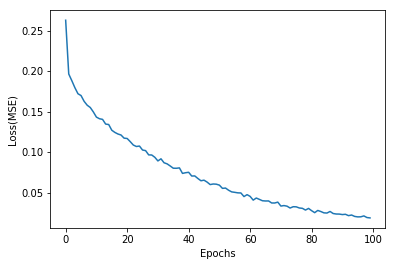

In [88]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

In [89]:
pred = model.predict(test_x)
r2 = r2_score(y_pred=pred, y_true=test_y)
r2

0.2982142115547154

### With coordinate transformation

In [6]:
features = {}
reorient_error_ids = []
fextract_error_ids = []
filepath = "features_dict.pickle"
if os.path.isfile(filepath):
    print("Loading features...", end='')
    with open(filepath, 'rb') as f:
        features = pickle.load(f)
    print("Done")
else:
    print("Extracting features", end='')
    # Get the pocket files
    data_dir = "../../pdbbind_data/"
    files = glob.glob(data_dir + "*/*/*_pocket.pdb", recursive=True)
    
    pbar = tqdm_notebook(total=len(files))
    for i, file in enumerate(files):
        # Get the molecule object using HTMD
        m = ht.Molecule(file)
        # Get the pdb id
        _id = m.viewname[:4] 
        # Avoid Residue insertion error
        m.renumberResidues() 
        # Re-orient the molecule object
        try:
            mol = reorient(m)
        except:
            reorient_error_ids.append(_id)
            pbar.update()
            continue
            #print("ERROR: REORIENTATION FOR ", _id)
        
        # Get the channels
        channel_map = mol.atomselect('protein') # Proteins are selected
        channels = np.ones([mol.numAtoms, 16], dtype=np.bool)
        for i, c_map in enumerate(channel_map):
            if c_map:
                channels[i, 8:] = False
            else:
                channels[i, :8] = False
        try:
            f, centers, natoms = vd.getVoxelDescriptors(mol, channels=channels)
            f = f.reshape(natoms[0], natoms[1], natoms[2], -1)
            features[_id] = f
        except:
            fextract_error_ids.append(_id)
            pbar.update()
            #print("ERROR: FEATURE EXTRACTION FOR ", _id)
            continue
        pbar.update()
    
    with open(filepath, "wb") as f:
        pickle.dump(features, f, pickle.HIGHEST_PROTOCOL)
    with open("reorient_error_ids.pickle", "wb") as f:
        pickle.dump(reorient_error_ids, f)
    with open("fextract_error_ids.pickle", "wb") as f:
        pickle.dump(fextract_error_ids, f)
    
    print("Done")

print("Feature dictionary length: ", len(features))

Loading features...Done
Feature dictionary length:  3867


In [260]:
reshaped = data_x.reshape((-1, 16))

In [151]:
np.amax(reshaped, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

The maximum values for each of the properties are 1

In [152]:
np.amin(reshaped, axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

The minimum values for each of the properties are 0

In [153]:
np.var(reshaped, axis=0)

array([0.03352465, 0.03352465, 0.03352465, 0.03352465, 0.03352465,
       0.03352465, 0.03352465, 0.03352465, 0.00220443, 0.00220443,
       0.00220443, 0.00220443, 0.00220443, 0.00220443, 0.00220443,
       0.00220443], dtype=float32)

In [185]:
[i and j for i, j in zip(np.any(reshaped>0, axis=0), np.any(reshaped<1, axis=0))]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

So there are values between 0 and 1.

Split

In [176]:
train_ids, valid_ids, test_ids = split_data(length=data_x.shape[0])

In [177]:
len(train_ids), len(valid_ids), len(test_ids)

(2952, 363, 363)

In [173]:
v = np.var(data_y)

In [174]:
data_y = data_y/v

Padding

In [13]:
data_x_path = 'bc_data_x'
data_y_filename = "data_y.pickle"

# Load the pdb_ids if available
if os.path.isfile(data_y_filename):
    with open(data_y_filename, 'rb') as f:
        print("Loading y data from the disk")
        data_y = pickle.load(f)

# Load the reshaped features if available
if os.path.isdir(data_x_path):
    print("Loading x data from the disk")
    data_x = bc.open(data_x_path)
    
else:
    print("Reshaping x_data and saving to the disk as '", data_x_path, "'")
    voxel_size = 50
    n_channels = 16
    xdata = np.zeros([len(valid_pdb_ids), voxel_size, voxel_size, voxel_size, n_channels], dtype=np.float32)
    data_y = np.zeros(len(valid_pdb_ids), dtype=np.float32)
    pbar = tqdm_notebook(total=len(valid_pdb_ids))
    count = 0
    for i, (k, f) in enumerate(features.items()):
        if not k in scores.keys():
            # We don't have a y-value for this pdb_id
            continue
        data_y[count] = scores[k]
        dim_diff = (xdata.shape[1:] - np.array(f.shape)).astype(int)
        pad_dim = np.round(dim_diff / 2).astype(int)
        f = np.pad(f, [(pad_dim[0], dim_diff[0]-pad_dim[0]),
                       (pad_dim[1], dim_diff[1]-pad_dim[1]),
                       (pad_dim[2], dim_diff[2]-pad_dim[2]),
                       (0, 0)],
                   'constant')
        xdata[count] = f
        count = count + 1
        pbar.update()
    
    # Create a bc array   
    data_x = bc.carray(xdata, rootdir=data_x_path)
    del xdata
    # Write to the disk
    data_x.flush()
    # Write the pdb ids
    with open(data_y_filename, 'wb') as f:
        pickle.dump(data_y, f)
        
print(data_x.shape, data_y.shape)

Reshaping x_data and saving to the disk as ' bc_data_x '


A Jupyter Widget

(3635, 50, 50, 50, 16) (3635,)


In [17]:
def generator(batch_size, mode='train'):
    global data_x
    global data_y
    global train_ids
    global valid_ids
    
    while True:
        if mode == 'train':
            rand_ids = np.random.choice(train_ids, batch_size)
            sample_x, sample_y = data_x[rand_ids], data_y[rand_ids]
        else:
            rand_ids = np.random.choice(valid_ids, batch_size)
            sample_x, sample_y = data_x[rand_ids], data_y[rand_ids]
        
        yield sample_x, sample_y

### Train

In [18]:
def get_model(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(5, 5, 5),
                     strides = (1, 1, 1),
                     input_shape=(50, 50, 50, 16),
                     padding='valid',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 4th layer group
#     model.add(Conv3D(filters=128,
#                      kernel_size=(3, 3, 3),
#                      activation='relu',
#                      padding='valid'))
    
#     model.add(MaxPooling3D(pool_size=(2, 2, 2),
#                            #strides=(1, 1, 1),
#                            padding='valid'))
    
    #model.add(AveragePooling3D(pool_size=(2, 2, 2), 
    #                           padding='valid'))
                           
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(256, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [19]:
get_model(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 46, 46, 46, 32)    64032     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 23, 23, 23, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 21, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 10, 10, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 8, 8, 128)      221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 4, 4, 4, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [112]:
# valid_y = valid_y / v

In [181]:
# checkpoint
print(model.metrics_names)
filepath="weights-improvement-{epoch:02d}-{mean_squared_error:.2f}.hdf5"
# For multi_gpu_model, save_weights_only should be set to True. Otherwise, saving of the multi_gpu_model will cause an error
checkpoint = ModelCheckpoint(filepath, 
                             monitor='mean_squared_error',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
callbacks_list = [checkpoint]

['loss', 'mean_squared_error']


In [131]:
nb_gpus = 8

In [182]:
nb_batch = nb_gpus*8
nb_epochs = 100
l_rate = 0.00001

In [183]:
model = get_model()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [168]:
history_sm = model.fit(x=data_x, y=data_y, epochs=nb_epochs, batch_size=nb_batch, verbose=1)

Epoch 1/100
3635/3635 [==============================] - 47s 13ms/step - loss: 5.1138 - mean_squared_error: 5.1138
Epoch 2/100
3635/3635 [==============================] - 44s 12ms/step - loss: 3.0986 - mean_squared_error: 3.0986
Epoch 3/100
3635/3635 [==============================] - 45s 12ms/step - loss: 3.0470 - mean_squared_error: 3.0470
Epoch 4/100
3635/3635 [==============================] - 44s 12ms/step - loss: 2.9875 - mean_squared_error: 2.9875
Epoch 5/100
3635/3635 [==============================] - 44s 12ms/step - loss: 2.9303 - mean_squared_error: 2.9303
Epoch 6/100
3635/3635 [==============================] - 45s 12ms/step - loss: 2.9026 - mean_squared_error: 2.9026
Epoch 7/100
3635/3635 [==============================] - 44s 12ms/step - loss: 2.8529 - mean_squared_error: 2.8529
Epoch 8/100
3635/3635 [==============================] - 44s 12ms/step - loss: 2.7997 - mean_squared_error: 2.7997
Epoch 9/100
3635/3635 [==============================] - 45s 12ms/step - loss: 2

#### Sample size = all <rb>
    Learning rate = 0.00001
    batch size = 32

After 100 epochs

In [199]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.9028615587381965


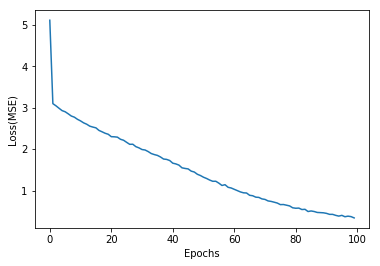

In [170]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

#### Sample size = 2048 <rb>
    Learning rate = 0.00001
    batch size = 16

After 100 epochs

In [162]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.9760152234465294


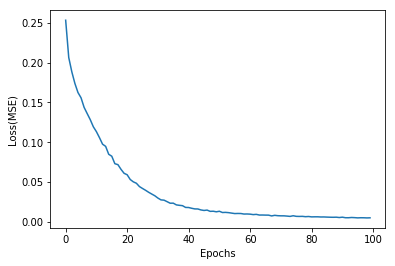

In [163]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

In [164]:
pred = model.predict(test_x)
r2 = r2_score(y_pred=pred, y_true=test_y)
r2

0.1737312829183537

#### Sample size = 512 <rb>
    Learning rate = 0.000001
    batch size = 16

In [136]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.47958324761957827


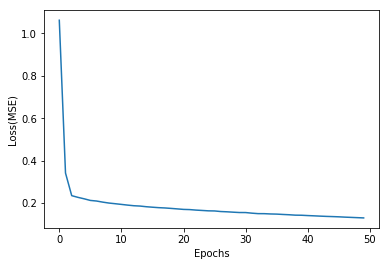

In [137]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

After another 50 epochs

In [139]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.6758009430184745


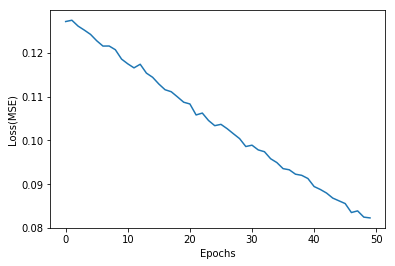

In [140]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

After another 100 epochs

In [143]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.906764049555101


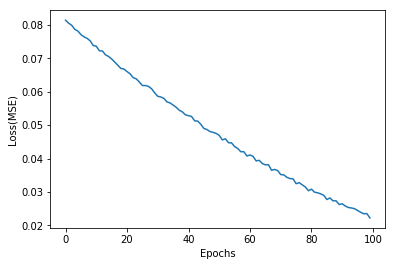

In [144]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

After another 200 epochs

In [146]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.9908617707690462


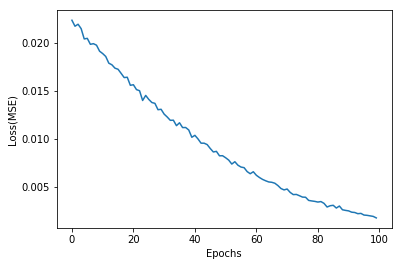

In [147]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

In [148]:
pred = model.predict(test_x)
r2 = r2_score(y_pred=pred, y_true=test_y)
r2

0.09775286726442589

#### Sample size = 128

In [117]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.9844373576233837


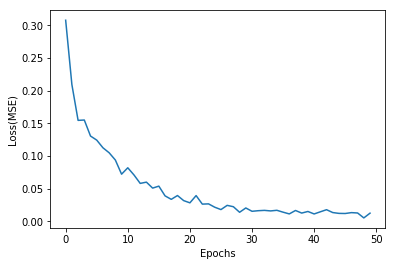

In [118]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

In [126]:
pred = model.predict(test_x)
r2 = r2_score(y_pred=pred, y_true=test_y)
r2

0.23172778936216853

#### Sample size = 1024

In [105]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.8500569271044498


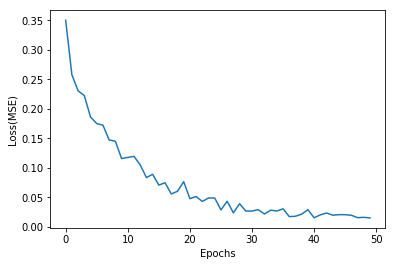

In [93]:
plt.plot(history_sm.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

In [184]:
history = model.fit_generator(generator(batch_size=nb_batch), #validation_data=(valid_x, valid_y),
                              epochs=nb_epochs,
                              steps_per_epoch=len(train_ids)//nb_batch, 
                              callbacks=callbacks_list, 
                              verbose=1)

Epoch 1/100
46/46 [==============================] - 27s 593ms/step - loss: 0.3172 - mean_squared_error: 0.3172

Epoch 00001: mean_squared_error improved from inf to 0.31716, saving model to weights-improvement-01-0.32.hdf5
Epoch 2/100
46/46 [==============================] - 26s 556ms/step - loss: 0.2058 - mean_squared_error: 0.2058

Epoch 00002: mean_squared_error improved from 0.31716 to 0.20585, saving model to weights-improvement-02-0.21.hdf5
Epoch 3/100
46/46 [==============================] - 26s 567ms/step - loss: 0.2111 - mean_squared_error: 0.2111

Epoch 00003: mean_squared_error did not improve
Epoch 4/100
46/46 [==============================] - 26s 561ms/step - loss: 0.1890 - mean_squared_error: 0.1890

Epoch 00004: mean_squared_error improved from 0.20585 to 0.18896, saving model to weights-improvement-04-0.19.hdf5
Epoch 5/100
46/46 [==============================] - 26s 560ms/step - loss: 0.1899 - mean_squared_error: 0.1899

Epoch 00005: mean_squared_error did not improv

46/46 [==============================] - 26s 559ms/step - loss: 0.0922 - mean_squared_error: 0.0922

Epoch 00041: mean_squared_error did not improve
Epoch 42/100
46/46 [==============================] - 26s 570ms/step - loss: 0.0889 - mean_squared_error: 0.0889

Epoch 00042: mean_squared_error improved from 0.08960 to 0.08886, saving model to weights-improvement-42-0.09.hdf5
Epoch 43/100
46/46 [==============================] - 26s 573ms/step - loss: 0.0811 - mean_squared_error: 0.0811

Epoch 00043: mean_squared_error improved from 0.08886 to 0.08105, saving model to weights-improvement-43-0.08.hdf5
Epoch 44/100
46/46 [==============================] - 27s 585ms/step - loss: 0.0797 - mean_squared_error: 0.0797

Epoch 00044: mean_squared_error improved from 0.08105 to 0.07965, saving model to weights-improvement-44-0.08.hdf5
Epoch 45/100
46/46 [==============================] - 26s 575ms/step - loss: 0.0846 - mean_squared_error: 0.0846

Epoch 00045: mean_squared_error did not improve
Ep

46/46 [==============================] - 26s 563ms/step - loss: 0.0375 - mean_squared_error: 0.0375

Epoch 00081: mean_squared_error did not improve
Epoch 82/100
46/46 [==============================] - 26s 559ms/step - loss: 0.0332 - mean_squared_error: 0.0332

Epoch 00082: mean_squared_error improved from 0.03627 to 0.03320, saving model to weights-improvement-82-0.03.hdf5
Epoch 83/100
46/46 [==============================] - 25s 548ms/step - loss: 0.0371 - mean_squared_error: 0.0371

Epoch 00083: mean_squared_error did not improve
Epoch 84/100
46/46 [==============================] - 26s 565ms/step - loss: 0.0343 - mean_squared_error: 0.0343

Epoch 00084: mean_squared_error did not improve
Epoch 85/100
46/46 [==============================] - 26s 563ms/step - loss: 0.0334 - mean_squared_error: 0.0334

Epoch 00085: mean_squared_error did not improve
Epoch 86/100
46/46 [==============================] - 26s 561ms/step - loss: 0.0318 - mean_squared_error: 0.0318

Epoch 00086: mean_squa

In [185]:
train_pred = model.predict(bx)
train_r2 = r2_score(y_pred=train_pred, y_true=by)
print("Training r2: {:4}".format(train_r2))

Training r2: 0.9028615587381965


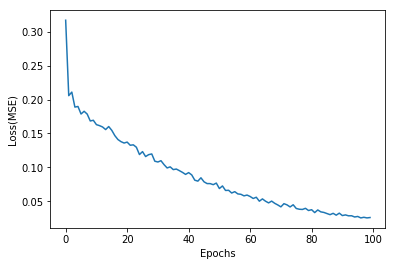

In [186]:
plt.plot(history.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
# plt.legend(["Validation", "Training"])
plt.show()

In [49]:
# Get the model and load the last saved weights
model = get_model()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.adam(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])
model.load_weights("weights-improvement-99-2.70.hdf5")

In [79]:
# model.save_weights("model-weights-40-2.28.hdf5")

In [80]:
sample_ids = train_ids[:50]

In [81]:
sample_train_x = x_data[sample_ids]

In [82]:
sample_train_y = y_data[sample_ids]

In [83]:
train_pred = model.predict(sample_train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=sample_train_y)
print("Training accuracy: {:4}".format(train_r2))

Training accuracy: 0.37042845648379974


Test performance

In [197]:
test_x, test_y = data_x[test_ids], data_y[test_ids]

In [198]:
pred = model.predict(test_x)
r2 = r2_score(y_pred=pred, y_true=test_y)
r2

0.15241912108523437